# Binary Classification

In [1]:
# Setup plotting
import matplotlib.pyplot as plt
# from learntools.deep_learning_intro.dltools import animate_sgd
print(plt.style.available)
plt.style.use('seaborn-whitegrid')
# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('animation', html='html5')


['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


In [3]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

hotel = pd.read_csv('./data/hotel.csv')
 
X = hotel.copy()
y = X.pop('is_canceled')

X['arrival_date_month'] = \
    X['arrival_date_month'].map(
        {'January':1, 'February': 2, 'March':3,
         'April':4, 'May':5, 'June':6, 'July':7,
         'August':8, 'September':9, 'October':10,
         'November':11, 'December':12}
    )

features_num = [
    "lead_time", "arrival_date_week_number",
    "arrival_date_day_of_month", "stays_in_weekend_nights",
    "stays_in_week_nights", "adults", "children", "babies",
    "is_repeated_guest", "previous_cancellations",
    "previous_bookings_not_canceled", "required_car_parking_spaces",
    "total_of_special_requests", "adr",
]
features_cat = [
    "hotel", "arrival_date_month", "meal",
    "market_segment", "distribution_channel",
    "reserved_room_type", "deposit_type", "customer_type",
]

transformer_num = make_pipeline(
    SimpleImputer(strategy="constant"), # there are a few missing values
    StandardScaler(),
)
transformer_cat = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="NA"),
    OneHotEncoder(handle_unknown='ignore'),
)

preprocessor = make_column_transformer(
    (transformer_num, features_num),
    (transformer_cat, features_cat),
)

# stratify - make sure classes are evenlly represented across splits
X_train, X_valid, y_train, y_valid = \
    train_test_split(X, y, stratify=y, train_size=0.75)

X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)

input_shape = [X_train.shape[1]]

In [4]:
from tensorflow import keras
from tensorflow.keras import layers

# YOUR CODE HERE: Add two 30% dropout layers, one after 128 and one after 64
model = keras.Sequential([
    layers.BatchNormalization(input_shape=input_shape),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

In [6]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)

Epoch 1/200
175/175 [==============================] - 10s 25ms/step - loss: 0.4799 - binary_accuracy: 0.7715 - val_loss: 0.4377 - val_binary_accuracy: 0.7864
Epoch 2/200
175/175 [==============================] - 4s 25ms/step - loss: 0.4217 - binary_accuracy: 0.8015 - val_loss: 0.4071 - val_binary_accuracy: 0.8070
Epoch 3/200
175/175 [==============================] - 4s 23ms/step - loss: 0.4077 - binary_accuracy: 0.8087 - val_loss: 0.3973 - val_binary_accuracy: 0.8156
Epoch 4/200
175/175 [==============================] - 4s 20ms/step - loss: 0.4012 - binary_accuracy: 0.8123 - val_loss: 0.3946 - val_binary_accuracy: 0.8171
Epoch 5/200
175/175 [==============================] - 4s 25ms/step - loss: 0.3964 - binary_accuracy: 0.8141 - val_loss: 0.3895 - val_binary_accuracy: 0.8208
Epoch 6/200
175/175 [==============================] - 4s 24ms/step - loss: 0.3918 - binary_accuracy: 0.8180 - val_loss: 0.3856 - val_binary_accuracy: 0.8240
Epoch 7/200
175/175 [==============================

<AxesSubplot:title={'center':'Accuracy'}>

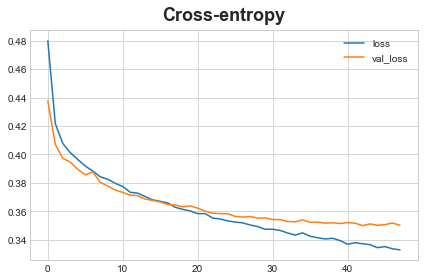

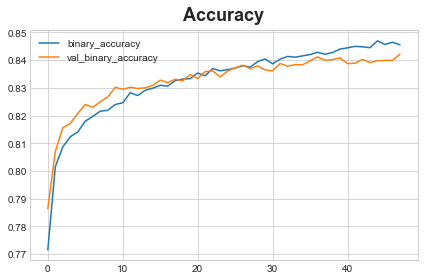

In [7]:
early_stopping = keras.callbacks.EarlyStopping(
    patience=5,
    min_delta=0.001,
    restore_best_weights=True,
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=200,
    callbacks=[early_stopping],
)

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot(title="Accuracy")